In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import copy
import warnings
warnings.filterwarnings('ignore')

import os
import sys

# Add library path to Python path
sys.path.append(os.path.abspath('..'))
from library.create_and_join_gtfs import create_gtfs_from_trips,save_gtfs_files

# Machine Learning
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    r2_score
)
from sklearn.cluster import KMeans

# ML Models
from sklearn.linear_model import (
    ElasticNet, 
    HuberRegressor,
    LinearRegression, 
    SGDRegressor,
    BayesianRidge
)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KernelDensity

# PyTorch and Pyro
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Statistics and Math
from scipy.stats import (
    loguniform,
    uniform,
    spearmanr, 
    pearsonr,
    gamma as scipy_gamma
)
from scipy.special import gamma as gamma_function, gammaln
import scipy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Other utilities
from datetime import datetime
from shapely import wkt


/home/medourahou1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:

legs_input_path = '../Cities/Padam_terretory_01/Ressources/cleaned_padam__drt_trips_terretory_01.csv' 




crs_import = 2154 #2154 # crs of the raw imported dat
crs_working = 2154 

# Toggle for preprocessing steps
# GTFS preprocessing to get hexagonal grid
#      --> needed once, can be skipped if GTFScells.csv file exists
toggle_GTFSprep = False
GTFScells_path = '../Cities/Padam_terretory_01/Ressources/cells_of_padam_terretory_01.csv'


In [3]:
trips_df= pd.read_csv(legs_input_path, sep=",")
dataset = trips_df[['departure_latitude_x', 'departure_longitude_x', 'arrival_latitude_x',
       'arrival_longitude_x', 'departure_time_hour',
       'departure_time_minute', 'departure_time_seconds',
       'departure_time_day_of_week', 'departure_time_day_of_month',
       'departure_time_month', 'departure_time_hour_sin',
       'departure_time_hour_cos', 'departure_time_day_of_week_sin',
       'departure_time_day_of_week_cos', 'departure_time_month_sin',
       'departure_time_month_cos', 'route_distance','travel_time']]

dataset.rename(columns = {   "departure_latitude_x" : 'departure_latitude',
                            "departure_longitude_x" : "departure_longitude",
                            "arrival_latitude_x" : 'arrival_latitude',
                            "arrival_longitude_x" : 'arrival_longitude'
                        
                          },inplace=True)

dataset = dataset[dataset["travel_time"]<=2500] #consider only travel times less than 40min
dataset =dataset[dataset["travel_time"]>=60] 

/tmp/ipykernel_1606851/1865277605.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.rename(columns = {   "departure_latitude_x" : 'departure_latitude',


In [5]:
dataset3

,departure_latitude,departure_longitude,arrival_latitude,arrival_longitude,departure_time_hour,departure_time_minute,departure_time_seconds,departure_time_day_of_week,departure_time_day_of_month,departure_time_month,departure_time_hour_sin,departure_time_hour_cos,departure_time_day_of_week_sin,departure_time_day_of_week_cos,departure_time_month_sin,departure_time_month_cos,route_distance,travel_time
0,48.881943,1.922480,48.866942,2.050021,21,23,23,2,18,10,-0.707107,0.707107,0.974928,-0.222521,-8.660254e-01,0.5,11656.6,1004.0
1,48.860352,2.015592,48.881943,1.922480,13,33,38,3,19,10,-0.258819,-0.965926,0.433884,-0.900969,-8.660254e-01,0.5,8276.8,648.0
2,48.866942,2.050021,48.881943,1.922480,14,48,42,4,20,10,-0.500000,-0.866025,-0.433884,-0.900969,-8.660254e-01,0.5,11940.3,1032.0
3,48.928584,1.864906,48.909181,1.856488,16,10,29,4,20,10,-0.866025,-0.500000,-0.433884,-0.900969,-8.660254e-01,0.5,3955.1,433.0
4,48.867554,1.970955,48.866942,2.050021,16,21,31,4,20,10,-0.866025,-0.500000,-0.433884,-0.900969,-8.660254e-01,0.5,7633.6,719.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246012,48.866873,2.050922,48.856033,2.019444,17,10,25,2,18,12,-0.965926,-0.258819,0.974928,-0.222521,-2.449294e-16,1.0,3070.9,359.0
246013,48.866873,2.050922,48.886380,1.923882,17,10,25,2,18,12,-0.965926,-0.258819,0.974928,-0.222521,-2.449294e-16,1.0,11608.1,913.0
246014,48.866873,2.050922,48.856033,2.019444,17,2,45,3,19,12,-0.965926,-0.258819,0.433884,-0.900969,-2.449294e-16,1.0,3070.9,359.0
246015,48.866873,2.050922,48.856033,2.019444,17,2,45,4,20,12,-0.965926,-0.258819,-0.433884,-0.900969,-2.449294e-16,1.0,3070.9,359.0


## 2. RandomForestRegressor with gamma distribution

In [143]:

class DistributionLearningModel:
    def __init__(self, n_estimators=100):
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            min_samples_leaf=5,
            max_features='sqrt',
            bootstrap=True,
            random_state=42
        )
        
    def fit(self, X, y):
        """
        Train the model on the given data.
        """
        self.model.fit(X, y)
        
    def predict_distribution(self, X, n_samples=2000):
        """
        Predict distribution parameters and generate samples.
        Returns a dictionary with samples and statistics.
        """
        predictions = []
        for estimator in self.model.estimators_:
            pred = estimator.predict(X)
            predictions.append(pred)
        
        predictions = np.array(predictions)
        
        # Calculate distribution parameters
        mean = np.mean(predictions, axis=0)
        std = np.std(predictions, axis=0)
        
        # Calculate gamma parameters
        alpha = (mean / std) ** 2  # shape
        beta = mean / (std ** 2)   # rate
        
        # Generate samples
        samples = np.array([
            np.random.gamma(alpha[i], 1/beta[i], n_samples)
            for i in range(len(X))
        ])
        
        # Calculate quantiles
        quantiles = np.percentile(samples.T, [5, 25, 50, 75, 95], axis=0)
        
        return {
            'predictions': samples.T,
            'mean': mean,
            'std': std,
            'alpha': alpha,
            'beta': beta,
            'quantiles': quantiles
        }
    
    def predict(self, X, n_samples=4000):
        """Alias for predict_distribution to maintain consistent interface"""
        return self.predict_distribution(X, n_samples)
    
    def compute_nll(self, y_true, predictions):
        """
        Compute Negative Log-Likelihood using gamma distribution.
        """
        # Ensure numerical stability
        epsilon = 1e-8
        alpha = np.maximum(predictions['alpha'], epsilon)
        beta = np.maximum(predictions['beta'], epsilon)
        y_true = np.maximum(y_true, epsilon)
        
        # Calculate log-likelihood for gamma distribution
        # log(P(x|α,β)) = α*log(β) - log(Γ(α)) + (α-1)*log(x) - β*x
        log_likelihood = (alpha * np.log(beta) - 
                        scipy.special.gammaln(alpha) + 
                        (alpha - 1) * np.log(y_true) - 
                        beta * y_true)
        
        return -np.mean(log_likelihood)
    
    def calculate_ece(self, y_true, predictions, n_bins=10):
        """
        Calculate Expected Calibration Error.
        """
        # Get confidence bounds
        lower_bounds = predictions['quantiles'][0]  # 5th percentile
        upper_bounds = predictions['quantiles'][4]  # 95th percentile
        
        # Calculate if actual values fall within the interval
        within_interval = np.logical_and(y_true >= lower_bounds, y_true <= upper_bounds)
        
        # Calculate predicted probabilities using gamma CDF
        confidences = np.zeros(len(y_true))
        for i in range(len(y_true)):
            confidences[i] = gamma.cdf(y_true[i], a=predictions['alpha'][i], 
                                     scale=1/predictions['beta'][i])
        
        # Sort by confidence
        sort_idx = np.argsort(confidences)
        confidences = confidences[sort_idx]
        within_interval = within_interval[sort_idx]
        
        # Calculate ECE
        ece = 0
        n_samples = len(y_true)
        samples_per_bin = n_samples // n_bins
        
        for i in range(n_bins):
            start_idx = i * samples_per_bin
            end_idx = start_idx + samples_per_bin if i < n_bins - 1 else n_samples
            
            bin_conf = np.mean(confidences[start_idx:end_idx])
            bin_acc = np.mean(within_interval[start_idx:end_idx])
            bin_weight = (end_idx - start_idx) / n_samples
            
            ece += bin_weight * np.abs(bin_acc - bin_conf)
        
        return ece
    
    def plot_credible_intervals(self, test_df, num_samples=100):
        """Plot predictions with credible intervals using quantiles."""
        # Extract features
        features = ['departure_latitude', 'departure_longitude', 'arrival_latitude',
                'arrival_longitude', 'departure_time_hour', 'departure_time_minute',
                'departure_time_seconds', 'departure_time_day_of_week',
                'departure_time_day_of_month', 'departure_time_month',
                'departure_time_hour_sin', 'departure_time_hour_cos',
                'departure_time_day_of_week_sin', 'departure_time_day_of_week_cos',
                'departure_time_month_sin', 'departure_time_month_cos',
                'route_distance']
        
        # Get predictions and actual values
        X_test = test_df[features].head(num_samples)
        predictions = self.predict(X_test)
        actual = test_df['travel_time'].values[:num_samples]
        
        # Sort by actual travel times
        sort_idx = np.argsort(actual)
        actual_sorted = actual[sort_idx]
        mean_sorted = predictions['mean'][sort_idx]
        
        # Get the 5th and 95th percentiles for the credible intervals
        lower_bounds = predictions['quantiles'][0][sort_idx]  # 5th percentile
        upper_bounds = predictions['quantiles'][4][sort_idx]  # 95th percentile
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.scatter(range(num_samples), actual_sorted, color='blue', label='Actual', alpha=0.7)
        plt.plot(range(num_samples), mean_sorted, color='red', label='Predicted Mean')
        plt.fill_between(range(num_samples), lower_bounds, upper_bounds, 
                        color='red', alpha=0.2, label='95% Credible Interval')
        plt.xlabel('Sample Index (sorted by actual travel time)')
        plt.ylabel('Travel Time (seconds)')
        plt.title('Actual vs Predicted Travel Time with 95% Credible Intervals')
        plt.legend()
        plt.show()

def run_distribution_learning(dataset):
    """
    Train and evaluate the distribution learning model with improved data handling.
    """
    # Prepare data - ensure we're working with a copy
    features = ['departure_latitude', 'departure_longitude', 'arrival_latitude',
                'arrival_longitude', 'departure_time_hour', 'departure_time_minute',
                'departure_time_seconds', 'departure_time_day_of_week',
                'departure_time_day_of_month', 'departure_time_month',
                'departure_time_hour_sin', 'departure_time_hour_cos',
                'departure_time_day_of_week_sin', 'departure_time_day_of_week_cos',
                'departure_time_month_sin', 'departure_time_month_cos',
                'route_distance']
    
    # Create copies to avoid SettingWithCopyWarning
    X = dataset[features].copy()
    y = dataset['travel_time'].copy()
    
    # Verify no NaN values before split
    assert not X.isna().any().any(), "NaN values found in features before split"
    assert not y.isna().any(), "NaN values found in target before split"
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Verify no NaN values after split
    assert not X_train.isna().any().any(), "NaN values found in X_train after split"
    assert not X_test.isna().any().any(), "NaN values found in X_test after split"
    assert not y_train.isna().any(), "NaN values found in y_train after split"
    assert not y_test.isna().any(), "NaN values found in y_test after split"
    
    # Train model
    print("Training model...")
    model = DistributionLearningModel(n_estimators=200)
    model.fit(X_train, y_train)
    
    # Generate predictions and compute metrics
    print("Generating predictions...")
    predictions = model.predict(X_test)
    
    # Create test_df safely
    test_df = pd.DataFrame(X_test, index=X_test.index)
    test_df['travel_time'] = y_test
    
    # Calculate metrics
    print("Computing metrics...")
    mean_predictions = predictions['mean']
    mae = np.mean(np.abs(y_test.values - mean_predictions))
    rmse = np.sqrt(np.mean((y_test.values - mean_predictions) ** 2))
    mape = np.mean(np.abs((y_test.values - mean_predictions) / y_test.values)) * 100
    nll = model.compute_nll(y_test.values, predictions)
    ece = model.calculate_ece(y_test.values, predictions)
    
    # Calculate percent within credible interval
    lower_bounds = predictions['quantiles'][0]  # 5th percentile
    upper_bounds = predictions['quantiles'][4]  # 95th percentile
    within_interval = np.logical_and(y_test.values >= lower_bounds, 
                                   y_test.values <= upper_bounds)
    percent_within_interval = np.mean(within_interval) * 100
    
    print("\nPerformance Metrics:")
    print(f"MAE: {mae:.2f} seconds")
    print(f"RMSE: {rmse:.2f} seconds")
    print(f"MAPE: {mape:.2f}%")
    print(f"NLL: {nll:.4f}")
    print(f"ECE: {ece:.4f}")
    print(f"Percentage within 95% credible interval: {percent_within_interval:.2f}%")
    
#     # Plot distributions
#     print("\nPlotting distributions...")
#     plot_distributions(y_test.values, predictions['predictions'])
    
#     # Plot credible intervals
#     print("Plotting credible intervals...")
#     model.plot_credible_intervals(test_df, num_samples=100)
    
    return model, test_df

def plot_distributions(actual, predicted, title="Distribution Comparison"):
    """
    Plot actual vs predicted distributions.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot actual distribution
    sns.histplot(actual, ax=ax1, stat="density", kde=True)
    ax1.set_title('Actual Travel Time Distribution')
    ax1.set_xlabel('Travel Time (seconds)')
    ax1.set_ylabel('Density')
    
    # Plot predicted distribution
    if isinstance(predicted, np.ndarray):
        pred_flat = predicted.flatten()
    else:
        pred_flat = predicted['predictions'].flatten()
        
    sns.histplot(pred_flat, ax=ax2, stat="density", kde=True)
    ax2.set_title('Predicted Travel Time Distribution')
    ax2.set_xlabel('Travel Time (seconds)')
    ax2.set_ylabel('Density')
    
    # Match axes limits
    xlim = (min(actual.min(), pred_flat.min()), max(actual.max(), pred_flat.max()))
    ylim = (0, max(ax1.get_ylim()[1], ax2.get_ylim()[1]))
    
    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    ax1.text(0.05, 0.95, f'Mean: {np.mean(actual):.1f}\nStd: {np.std(actual):.1f}', 
                transform=ax1.transAxes, verticalalignment='top')
    ax2.text(0.05, 0.95, f'Mean: {np.mean(pred_flat):.1f}\nStd: {np.std(pred_flat):.1f}', 
                transform=ax2.transAxes, verticalalignment='top')
    plt.tight_layout()
    plt.show()



"\n# Load your dataset\ndataset = pd.read_csv('your_data.csv')\n\n# Train and evaluate the model\nmodel, test_df = run_distribution_learning(dataset)\n"

In [144]:

model_random_forest, test_df =run_distribution_learning(dataset3)

Training model...
Generating predictions...
Computing metrics...

Performance Metrics:
MAE: 176.33 seconds
RMSE: 255.42 seconds
MAPE: 30.19%
NLL: 6.9721
ECE: 0.5717
Percentage within 95% credible interval: 78.73%


## 2. Bayesian Neural Network model

In [19]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')
pyro.set_rng_seed(0)

class BNNTravelTimeModel(PyroModule):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        # Set default dtype for all tensors
        torch.set_default_dtype(torch.float32)
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Initialize parameters with consistent dtype
        df = torch.tensor(9.815853992105808, dtype=torch.float32).to(device)
        loc = torch.tensor(0.0, dtype=torch.float32).to(device)
        scale = torch.tensor(1.0044249756892316, dtype=torch.float32).to(device)
      
        self.fc1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(
            dist.StudentT(df=df, loc=loc, scale=scale)
            .expand([hidden_dim, input_dim]).to_event(2)
        )
        self.fc1.bias = PyroSample(
            dist.StudentT(df=df, loc=loc, scale=scale)
            .expand([hidden_dim]).to_event(1)
        )
        
        self.fc2 = PyroModule[nn.Linear](hidden_dim, 1)
        self.fc2.weight = PyroSample(
            dist.StudentT(df=df, loc=loc, scale=scale)
            .expand([1, hidden_dim]).to_event(2)
        )
        self.fc2.bias = PyroSample(
            dist.StudentT(df=df, loc=loc, scale=scale)
            .expand([1]).to_event(1)
        )
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        
        # Move model to device
        self = self.to(device)
        

    def forward_custom(self, x, y, gamma_concentration, gamma_rate, min_rate, max_rate):
        x = x.to(device).float()
        if y is not None:
            y = y.to(device).float()

        hidden = self.relu(self.fc1(x))
        mean = self.softplus(self.fc2(hidden)).squeeze(-1) #+ 60

        rate = pyro.sample("rate", dist.Gamma(gamma_concentration, gamma_rate))
        rate = torch.clamp(rate, min=min_rate, max=max_rate)

        # Control the shape parameter more strictly
        shape = torch.clamp(mean, min=45.0)  

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample(
                "obs",
                dist.Gamma(shape, rate),
                obs=y
            )

        return mean

    def forward(self, x, y=None):
        return self.forward_custom(
            x, y,
            gamma_concentration=39.74707591011395,  
            gamma_rate=10.74048916199396,          
            min_rate=2.698555968291381,           
            max_rate=3.000885709840137 

        )
        

class DRTTravelTimePredictorBNN:
    def __init__(self, input_dim, hidden_dim=16):
       
        pyro.clear_param_store()
        
        # Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize model and move to device
        self.model = BNNTravelTimeModel(input_dim, hidden_dim)
        self.model.to(self.device)
        
        # Initialize guide and move to device
        self.guide = pyro.infer.autoguide.AutoDiagonalNormal(self.model)
        self.guide.to(self.device)
        
        self.svi = None
        self.training_losses = []
        # self.training_losses = []
    def prepare_data(self, df, has_target=True):
        """
        Prepare data for training or evaluation with consistent dtype.

        Parameters:
        -----------
        df : pandas DataFrame
            Input DataFrame
        has_target : bool
            Whether the DataFrame contains the target variable (travel_time)
        """
        features = df[['departure_latitude', 'departure_longitude', 'arrival_latitude',
                    'arrival_longitude', 'departure_time_hour', 'departure_time_minute',
                    'departure_time_seconds', 'departure_time_day_of_week',
                    'departure_time_day_of_month', 'departure_time_month',
                    'departure_time_hour_sin', 'departure_time_hour_cos',
                    'departure_time_day_of_week_sin', 'departure_time_day_of_week_cos',
                    'departure_time_month_sin', 'departure_time_month_cos',
                    'route_distance']].values

        # Clean features
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
        features_tensor = torch.tensor(features, dtype=torch.float32).to(device)

        if has_target:
            travel_time = df['travel_time'].values
            travel_time = np.nan_to_num(travel_time, nan=0.0, posinf=0.0, neginf=0.0)
            travel_time_tensor = torch.tensor(travel_time, dtype=torch.float32).to(device)
            return features_tensor, travel_time_tensor

        return features_tensor, None
 
    def train(self, train_df, num_epochs=1000, lr=0.01, patience=60, batch_size=100000):
        """
        Train the Bayesian Neural Network model.
        """
        # Prepare data
        features, travel_time = self.prepare_data(train_df)
        
        # Basic DataLoader without any special configurations
        dataset = TensorDataset(features, travel_time)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        self.training_losses = []
        losses = []

        # Initialize SVI if not already done
        if self.svi is None:
            optimizer = pyro.optim.Adam({"lr": lr})
            self.svi = SVI(self.model, self.guide, optimizer, loss=Trace_ELBO())
        
        # Training variables
        best_loss = float('inf')
        best_state_dict = None
        patience_counter = 0
        epochs_trained = 0
        
        try:
            for epoch in range(num_epochs):
                epoch_losses = []
                
                # Manual shuffling on GPU
                perm = torch.randperm(len(features), device='cuda')
                shuffled_features = features[perm]
                shuffled_travel_time = travel_time[perm]
                
                # Create new DataLoader with shuffled data
                shuffled_dataset = TensorDataset(shuffled_features, shuffled_travel_time)
                train_loader = DataLoader(shuffled_dataset, batch_size=batch_size)
                
                for batch_X, batch_y in train_loader:
                    loss = self.svi.step(batch_X, batch_y)
                    epoch_losses.append(loss)
                    
            
                
                avg_epoch_loss = np.mean(epoch_losses)
                self.training_losses.append(avg_epoch_loss)
                losses.append(avg_epoch_loss)
                
                if avg_epoch_loss < best_loss:
                    best_loss = avg_epoch_loss
                    best_state_dict = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if (epoch + 1) % 1 == 0:
                    # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")
                    self.plot_training_loss(self.training_losses)
                
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    epochs_trained = epoch + 1
                    break
                
                epochs_trained = epoch + 1
            
            if best_state_dict is not None:
                self.model.load_state_dict(best_state_dict)
                
        except Exception as e:
            print(f"Training error: {str(e)}")
            raise
        
        print(f"\nTraining completed after {epochs_trained} epochs")
        print(f"Final best loss: {best_loss:.4f}")
        
        return epochs_trained
    def predict(self, test_df, num_samples=4000):
        """
        Make predictions for the test data.
        """
        features, _ = self.prepare_data(test_df, has_target=False)
        try:
            predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=num_samples)
            predictions = predictive(features)
            pred_samples = predictions["obs"].cpu().detach().numpy()

            means = pred_samples.mean(axis=0)
            stds = pred_samples.std(axis=0)
            quantiles = np.percentile(pred_samples, [5, 25, 50, 75, 95], axis=0)

            return {
                'mean': means,
                'std': stds,
                'predictions': pred_samples,
                'quantiles': quantiles
            }

        except Exception as e:
            print(f"Error during prediction: {str(e)}")
            raise


    

    



    def calculate_credible_intervals(self, predictions, confidence=0.95):
        alpha = (predictions['mean'] / predictions['std'])**2
        beta = predictions['mean'] / (predictions['std']**2)
        
        lower_bounds = scipy_gamma.ppf((1 - confidence) / 2, a=alpha, scale=1/beta)
        upper_bounds = scipy_gamma.ppf((1 + confidence) / 2, a=alpha, scale=1/beta)
        
        return lower_bounds, upper_bounds

    def calculate_percent_within_interval(self, actual, lower_bounds, upper_bounds):
        """
        Calculate the percentage of actual values that lie within the 95% credible interval.
        """
        within_interval = np.logical_and(actual >= lower_bounds, actual <= upper_bounds)
        percent_within_interval = np.mean(within_interval) * 100
        return percent_within_interval

    def evaluate(self, test_df):
        predictions = self.predict(test_df)
        actual = test_df['travel_time'].values

        # Basic metrics
        mae = np.mean(np.abs(predictions['mean'] - actual))
        rmse = np.sqrt(np.mean((predictions['mean'] - actual) ** 2))
        mape = np.mean(np.abs((predictions['mean'] - actual) / actual)) * 100
        r2 = 1 - np.sum((actual - predictions['mean'])**2) / np.sum((actual - np.mean(actual))**2)
        explained_variance = 1 - np.var(actual - predictions['mean']) / np.var(actual)

        # Compute Negative Log-Likelihood (NLL) for the Gamma distribution
        # Calculate shape (α) and rate (β) parameters
        alpha = (predictions['mean'] / predictions['std'])**2  # shape parameter
        beta = predictions['mean'] / (predictions['std']**2)   # rate parameter

        # Ensure numerical stability
        epsilon = 1e-8
        alpha = np.maximum(alpha, epsilon)
        beta = np.maximum(beta, epsilon)
        actual = np.maximum(actual, epsilon)

        # Manual calculation of Gamma log-likelihood
        # log(P(x|α,β)) = α*log(β) - log(Γ(α)) + (α-1)*log(x) - β*x
        gamma_loglik = (alpha * np.log(beta) - 
                       scipy.special.gammaln(alpha) + 
                       (alpha - 1) * np.log(actual) - 
                       beta * actual)

        # Average negative log-likelihood
        nll = -np.mean(gamma_loglik)

        # Calculate credible intervals
        lower_bounds, upper_bounds = self.calculate_credible_intervals(predictions)
        within_interval = np.logical_and(actual >= lower_bounds, actual <= upper_bounds)
        percent_within_interval = np.mean(within_interval) * 100

        # Calculate ECE with adaptive binning
        n_samples = len(actual)
        min_samples_per_bin = 100
        n_bins = max(10, n_samples // min_samples_per_bin)  # At least 10 bins, but ensure enough samples per bin

        # Calculate confidences using Gamma CDF
        confidences = np.zeros(len(actual))
        for i in range(len(actual)):
            confidences[i] = scipy.stats.gamma.cdf(actual[i], a=alpha[i], scale=1/beta[i])

        # Sort confidences and corresponding actuals
        sort_idx = np.argsort(confidences)
        confidences = confidences[sort_idx]
        actual_sorted = actual[sort_idx]

        # Create bins with approximately equal number of samples
        bin_boundaries = np.interp(
            np.linspace(0, n_samples, n_bins + 1),
            np.arange(n_samples),
            confidences
        )

        # Calculate ECE
        ece = 0
        bin_stats = []

        for i in range(n_bins):
            bin_mask = (confidences >= bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
            bin_samples = np.sum(bin_mask)

            if bin_samples > 0:
                bin_conf = np.mean(confidences[bin_mask])
                bin_acc = np.mean(within_interval[sort_idx][bin_mask])
                bin_weight = bin_samples / n_samples
                ece += bin_weight * np.abs(bin_acc - bin_conf)

                bin_stats.append({
                    'samples': bin_samples,
                    'confidence': bin_conf,
                    'accuracy': bin_acc
                })

        # Print all metrics
        print(f"MAE: {mae:.2f} seconds")
        print(f"RMSE: {rmse:.2f} seconds")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}")
        print(f"Explained Variance: {explained_variance:.4f}")
        print(f"Negative Log-Likelihood (NLL): {nll:.4f}")
        print(f"Expected Calibration Error (ECE): {ece:.4f}")
        print(f"Percentage within 95% credible interval: {percent_within_interval:.2f}%")
        

        return {
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'nll': nll,
            'ece': ece,
            'r2': r2,
            'explained_variance': explained_variance,
            'predictions': predictions,
            'credible_intervals': (lower_bounds, upper_bounds),
            'percent_within_interval': percent_within_interval,
            'alpha': alpha,
            'beta': beta,
            'bin_stats': bin_stats
        }


    

    def plot_training_loss(self, losses):
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(losses)
        plt.title('Training Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.grid(True)
        plt.show()
        
    def plot_distributions(self, test_df):
        import seaborn as sns

        # Get predictions
        predictions = self.predict(test_df, num_samples=500)
        actual = test_df['travel_time'].values

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot actual distribution
        sns.histplot(actual, ax=ax1, stat="density", kde=True)
        ax1.set_title('Actual Travel Time Distribution')
        ax1.set_xlabel('Travel Time (seconds)')
        ax1.set_ylabel('Density')

        # Plot predicted distribution
        pred_flat = predictions['predictions'].flatten()
        sns.histplot(pred_flat, ax=ax2, stat="density", kde=True)
        ax2.set_title('Predicted Travel Time Distribution')
        ax2.set_xlabel('Travel Time (seconds)')
        ax2.set_ylabel('Density')

        # Get the overall min and max values for both x and y axes
        x_min = min(actual.min(), pred_flat.min())
        x_max = max(actual.max(), pred_flat.max())
        y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

        # Set the same limits for both plots
        ax1.set_xlim(x_min, x_max)
        ax2.set_xlim(x_min, x_max)
        ax1.set_ylim(0, y_max)
        ax2.set_ylim(0, y_max)

        plt.tight_layout()
        plt.show()

    def plot_credible_intervals(self, test_df, num_samples=100):
        import matplotlib.pyplot as plt

        predictions = self.predict(test_df.head(num_samples))
        actual = test_df['travel_time'].values[:num_samples]
        lower_bounds, upper_bounds = self.calculate_credible_intervals(predictions)

        plt.figure(figsize=(12, 6))
        plt.scatter(range(num_samples), actual, color='blue', label='Actual', alpha=0.7)
        plt.plot(range(num_samples), predictions['mean'], color='red', label='Predicted Mean')
        plt.fill_between(range(num_samples), lower_bounds, upper_bounds, color='red', alpha=0.2, label='95% Credible Interval')
        plt.xlabel('Sample Index')
        plt.ylabel('Travel Time (seconds)')
        plt.title('Actual vs Predicted Travel Time with 95% Credible Intervals')
        plt.legend()
        plt.show()
        
    def predict_thresholds(self, new_data, confidence_levels=[0.95, 0.50]):
        """
        Predict travel time thresholds for given confidence levels.
        """
        predictions = self.predict(new_data, num_samples=4000)
        pred_samples = predictions['predictions']

        thresholds = {}
        for conf in confidence_levels:
            upper_percentile = 100 * (1 + conf) / 2
            thresholds[conf] = {
                'threshold': np.percentile(pred_samples, upper_percentile, axis=0),
                'mean': predictions['mean'],
                'std': predictions['std']
            }

        return thresholds

    def evaluate_thresholds(self, test_df, confidence_levels=[0.95, 0.50]):
        """
        Evaluate threshold predictions against actual values.

        Parameters:
        -----------
        test_df : pandas DataFrame
            Test data with actual travel times
        confidence_levels : list
            List of confidence levels to evaluate

        Returns:
        --------
        dict : Dictionary containing evaluation metrics for each confidence level
        """
        thresholds = self.predict_thresholds(test_df, confidence_levels)
        actual = test_df['travel_time'].values

        results = {}
        for conf in confidence_levels:
            threshold = thresholds[conf]['threshold']
            within_threshold = actual <= threshold
            accuracy = np.mean(within_threshold) * 100

            mae = np.mean(np.abs(threshold - actual))
            rmse = np.sqrt(np.mean((threshold - actual) ** 2))

            results[conf] = {
                'accuracy': accuracy,
                'mae': mae,
                'rmse': rmse,
                'mean_threshold': np.mean(threshold),
                'std_threshold': np.std(threshold)
            }

        return results

    def plot_threshold_predictions(self, test_df, num_samples=100, confidence_levels=[0.95, 0.50]):
        """
        Plot actual travel times against predicted thresholds.

        Parameters:
        -----------
        test_df : pandas DataFrame
            Test data with actual travel times
        num_samples : int
            Number of samples to plot
        confidence_levels : list
            List of confidence levels to plot
        """
        thresholds = self.predict_thresholds(test_df.head(num_samples), confidence_levels)
        actual = test_df['travel_time'].values[:num_samples]

        plt.figure(figsize=(12, 6))
        plt.scatter(range(num_samples), actual, color='blue', label='Actual', alpha=0.7)

        colors = ['red', 'green']
        for conf, color in zip(confidence_levels, colors):
            threshold = thresholds[conf]['threshold']
            plt.plot(range(num_samples), threshold, 
                    color=color, 
                    label=f'{int(conf*100)}% Threshold',
                    linestyle='--')

        plt.xlabel('Sample Index')
        plt.ylabel('Travel Time (seconds)')
        plt.title('Actual Travel Times vs Predicted Thresholds')
        plt.legend()
        plt.show()
    def plot_credible_intervals(self, test_df, num_samples=100):
        """Plot predictions with credible intervals using quantiles."""
        # Get predictions and actual values
        predictions = self.predict(test_df.head(num_samples))
        actual = test_df['travel_time'].values[:num_samples]

        # Sort by actual travel times
        sort_idx = np.argsort(actual)
        actual_sorted = actual[sort_idx]
        mean_sorted = predictions['mean'][sort_idx]

        # Get the 5th and 95th percentiles for the credible intervals
        lower_bounds = predictions['quantiles'][0][sort_idx]  # 5th percentile
        upper_bounds = predictions['quantiles'][4][sort_idx]  # 95th percentile

        # Plot
        plt.figure(figsize=(12, 6))
        plt.scatter(range(num_samples), actual_sorted, color='blue', label='Actual', alpha=0.7)
        plt.plot(range(num_samples), mean_sorted, color='red', label='Predicted Mean')
        plt.fill_between(range(num_samples), lower_bounds, upper_bounds, 
                        color='red', alpha=0.2, label='95% Credible Interval')
        plt.xlabel('Sample Index (sorted by actual travel time)')
        plt.ylabel('Travel Time (seconds)')
        plt.title('Actual vs Predicted Travel Time with 95% Credible Intervals')
        plt.legend()
        plt.show()

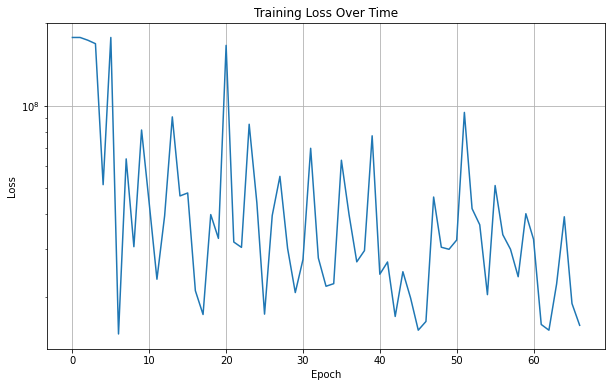

Early stopping triggered at epoch 67

Training completed after 67 epochs
Final best loss: 14616281.3865


67

In [21]:
train_data, test_data = train_test_split(dataset3, test_size=0.2, random_state=42)
torch.cuda.empty_cache()
BNN_model = DRTTravelTimePredictorBNN(input_dim=17,hidden_dim=32)#8#64
BNN_model.train(train_data, num_epochs=800, lr=0.023021932308657945)#10 EPOCHSlr=0.022332138825158766



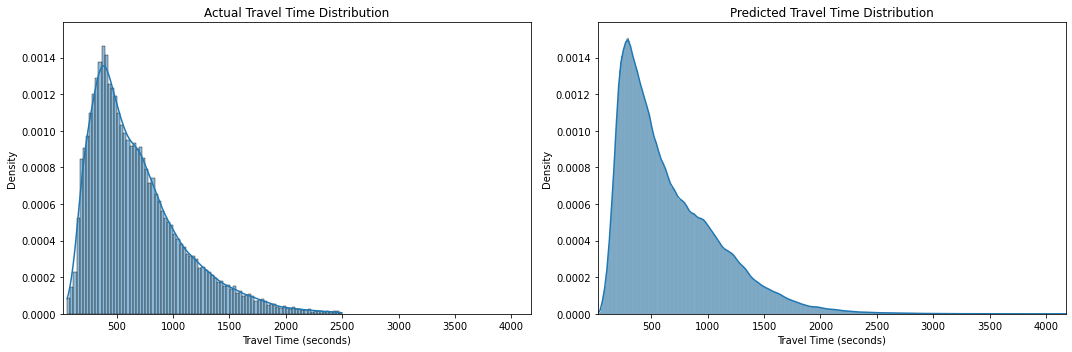

In [22]:
BNN_model.plot_distributions(test_data)

## 3. Conditioal Kernel Density Estimation

In [23]:


class StableGammaKernelDensityEstimator:
    def __init__(self, bandwidth='scott'):
        self.bandwidth_method = bandwidth
        self.bandwidth = None
        self.samples = None
        
    def _compute_scott_bandwidth(self, data):
        n = len(data)
        sigma = np.std(data)
        return sigma * np.power(n, -1/5)
    
    def fit(self, x):
        self.samples = np.maximum(x.reshape(-1), 1e-6)
        self.scale_factor = np.median(self.samples)
        self.samples = self.samples / self.scale_factor
        
        if self.bandwidth_method == 'scott':
            self.bandwidth = self._compute_scott_bandwidth(self.samples)
        else:
            self.bandwidth = self.bandwidth_method
            
        return self
    
    def _log_gamma_kernel(self, x, y):
        b = self.bandwidth
        x = np.maximum(x, 1e-6) / self.scale_factor
        y = np.maximum(y, 1e-6) / self.scale_factor
        
        rho = y/b
        
        log_norm = rho * np.log(y) - rho * np.log(b) - gammaln(rho)
        log_kernel = (rho - 1) * np.log(x) - x/b
        
        return log_norm + log_kernel
    
    def score_samples(self, x):
        x = np.atleast_1d(x)
        log_densities = np.zeros(len(x))
        
        for i, xi in enumerate(x):
            log_kernels = self._log_gamma_kernel(xi, self.samples)
            max_log_kernel = np.max(log_kernels)
            log_densities[i] = max_log_kernel + np.log(np.mean(
                np.exp(log_kernels - max_log_kernel)
            ))
        
        log_densities -= np.log(self.scale_factor)
        return log_densities
    
    def sample(self, n_samples):
        idx = np.random.randint(0, len(self.samples), n_samples)
        base_samples = self.samples[idx]
        
        shape = np.maximum(base_samples/self.bandwidth, 1e-6)
        scale = self.bandwidth
        samples = np.random.gamma(shape, scale)
        
        return np.maximum(samples * self.scale_factor, 1e-6)

class ConditionalGammaKDEBaseline(BaseEstimator, RegressorMixin):
    def __init__(self, n_clusters=50, bandwidth='scott'):
        self.n_clusters = n_clusters
        self.bandwidth = bandwidth
        self.feature_scaler = StandardScaler()
        self.clusterer = KMeans(n_clusters=n_clusters)
        self.kdes = {}
        self.bandwidths = {}
    
    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        
        X_scaled = self.feature_scaler.fit_transform(X)
        y_positive = np.maximum(y, 1e-6)
        
        self.clusterer.fit(X_scaled)
        clusters = self.clusterer.predict(X_scaled)
        
        for cluster_id in range(self.n_clusters):
            cluster_mask = (clusters == cluster_id)
            if np.sum(cluster_mask) > 10:
                cluster_times = y_positive[cluster_mask]
                kde = StableGammaKernelDensityEstimator(bandwidth=self.bandwidth)
                kde.fit(cluster_times)
                self.kdes[cluster_id] = kde
                self.bandwidths[cluster_id] = kde.bandwidth
        
        if self.bandwidth == 'scott':
            avg_bandwidth = np.mean(list(self.bandwidths.values()))
            print(f"Average Scott's rule bandwidth: {avg_bandwidth:.4f}")
        
        return self
    
    def predict_distribution(self, X, n_samples=1000):
        X = np.asarray(X, dtype=np.float64)
        X_scaled = self.feature_scaler.transform(X)
        clusters = self.clusterer.predict(X_scaled)
        samples = np.zeros((len(X), n_samples))
        
        for i, cluster_id in enumerate(clusters):
            if cluster_id in self.kdes:
                samples[i] = self.kdes[cluster_id].sample(n_samples)
            else:
                distances = np.linalg.norm(
                    self.clusterer.cluster_centers_ - X_scaled[i], 
                    axis=1
                )
                nearest_cluster = np.argmin(distances)
                samples[i] = self.kdes[nearest_cluster].sample(n_samples)
        
        return np.maximum(samples, 1e-6)

    def predict_distribution_with_stats(self, X, n_samples=4000):
        """
        Predict distribution and return statistics including quantiles.
        """
        samples = self.predict_distribution(X, n_samples)
        mean = np.mean(samples, axis=1)
        std = np.std(samples, axis=1)
        quantiles = np.percentile(samples, [5, 25, 50, 75, 95], axis=1)

        return {
            'predictions': samples,
            'mean': mean,
            'std': std,
            'quantiles': quantiles
        }
    
    def predict(self, X):
        samples = self.predict_distribution(X, n_samples=1000)
        return np.mean(samples, axis=1)
    
    def compute_nll(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        
        X_scaled = self.feature_scaler.transform(X)
        clusters = self.clusterer.predict(X_scaled)
        y_positive = np.maximum(y, 1e-6)
        
        log_likelihoods = np.zeros(len(X))
        
        for i, (cluster_id, time) in enumerate(zip(clusters, y_positive)):
            if cluster_id in self.kdes:
                log_likelihoods[i] = self.kdes[cluster_id].score_samples(np.array([time]))[0]
            else:
                distances = np.linalg.norm(
                    self.clusterer.cluster_centers_ - X_scaled[i], 
                    axis=1
                )
                nearest_cluster = np.argmin(distances)
                log_likelihoods[i] = self.kdes[nearest_cluster].score_samples(np.array([time]))[0]
        
        return -np.mean(log_likelihoods)
    
    def plot_credible_intervals(self, test_df, num_samples=100):
        """Plot predictions with credible intervals using quantiles."""
        # Extract features
        features = ['departure_latitude', 'departure_longitude', 'arrival_latitude',
                   'arrival_longitude', 'departure_time_hour', 'departure_time_minute',
                   'departure_time_seconds', 'departure_time_day_of_week',
                   'departure_time_day_of_month', 'departure_time_month',
                   'departure_time_hour_sin', 'departure_time_hour_cos',
                   'departure_time_day_of_week_sin', 'departure_time_day_of_week_cos',
                   'departure_time_month_sin', 'departure_time_month_cos',
                   'route_distance']
        
        # Get predictions and actual values
        X_test = test_df[features].head(num_samples).values
        predictions = self.predict_distribution_with_stats(X_test)
        actual = test_df['travel_time'].values[:num_samples]
        
        # Sort by actual travel times
        sort_idx = np.argsort(actual)
        actual_sorted = actual[sort_idx]
        mean_sorted = predictions['mean'][sort_idx]
        
        # Get the 5th and 95th percentiles for the credible intervals
        lower_bounds = predictions['quantiles'][0][sort_idx]  # 5th percentile
        upper_bounds = predictions['quantiles'][4][sort_idx]  # 95th percentile
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.scatter(range(num_samples), actual_sorted, color='blue', label='Actual', alpha=0.7)
        plt.plot(range(num_samples), mean_sorted, color='red', label='Predicted Mean')
        plt.fill_between(range(num_samples), lower_bounds, upper_bounds, 
                        color='red', alpha=0.2, label='95% Credible Interval')
        plt.xlabel('Sample Index (sorted by actual travel time)')
        plt.ylabel('Travel Time (seconds)')
        plt.title('Actual vs Predicted Travel Time with 95% Credible Intervals')
        plt.legend()
        plt.show()
    
    def evaluate(self, X, y):
        predictions_with_stats = self.predict_distribution_with_stats(X)
        predictions = predictions_with_stats['mean']
        samples = predictions_with_stats['predictions']
        nll = self.compute_nll(X, y)
        
        mae = mean_absolute_error(y, predictions)
        rmse = np.sqrt(mean_squared_error(y, predictions))
        r2 = r2_score(y, predictions)
        mape = np.mean(np.abs((y - predictions) / y)) * 100
        
        intervals = {
            '90%': np.percentile(samples, [5, 95], axis=1).T,
            '95%': np.percentile(samples, [2.5, 97.5], axis=1).T
        }
        
        coverage = {
            '90%': np.mean((y >= intervals['90%'][:, 0]) & 
                          (y <= intervals['90%'][:, 1])) * 100,
            '95%': np.mean((y >= intervals['95%'][:, 0]) & 
                          (y <= intervals['95%'][:, 1])) * 100
        }
        
        print(f"\nPerformance Metrics:")
        print(f"MAE: {mae:.2f} seconds")
        print(f"RMSE: {rmse:.2f} seconds")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}")
        print(f"NLL: {nll:.4f}")
        print(f"Coverage within 95% interval: {coverage['95%']:.2f}%")
        print(f"Coverage within 90% interval: {coverage['90%']:.2f}%")
        
        return {
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'r2': r2,
            'nll': nll,
            'coverage': coverage,
            'intervals': intervals,
            'predictions': predictions_with_stats
        }
    
    def plot_distributions(self, X_test, y_test, n_samples=4000, bins=50):
        samples = self.predict_distribution(X_test, n_samples)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot actual distribution
        sns.histplot(y_test, ax=ax1, stat="density", kde=True, bins=bins,
                    color='skyblue', alpha=0.6)
        ax1.set_title('Actual Travel Time Distribution')
        ax1.set_xlabel('Travel Time (seconds)')
        ax1.set_ylabel('Density')
        
        # Plot predicted distribution
        sns.histplot(samples.flatten(), ax=ax2, stat="density", kde=True, bins=bins,
                    color='skyblue', alpha=0.6)
        ax2.set_title('Predicted Travel Time Distribution')
        ax2.set_xlabel('Travel Time (seconds)')
        ax2.set_ylabel('Density')
        
        # Match axes limits
        x_min = min(y_test.min(), samples.min())
        x_max = max(y_test.max(), samples.max())
        y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
        
        # Set consistent limits for both plots
        ax1.set_xlim(x_min, x_max)
        ax2.set_xlim(x_min, x_max)
        ax1.set_ylim(0, y_max)
        ax2.set_ylim(0, y_max)
        
        # Add summary statistics
        ax1.text(0.05, 0.95, f'Mean: {np.mean(y_test):.1f}\nStd: {np.std(y_test):.1f}', 
                transform=ax1.transAxes, verticalalignment='top')
        ax2.text(0.05, 0.95, f'Mean: {np.mean(samples):.1f}\nStd: {np.std(samples):.1f}', 
                transform=ax2.transAxes, verticalalignment='top')
        
        plt.tight_layout()
        plt.show()

def prepare_data(df):
    features = df[['departure_latitude', 'departure_longitude', 
                  'arrival_latitude', 'arrival_longitude', 
                  'departure_time_hour', 'departure_time_minute',
                  'departure_time_seconds', 'departure_time_day_of_week',
                  'departure_time_day_of_month', 'departure_time_month',
                  'departure_time_hour_sin', 'departure_time_hour_cos',
                  'departure_time_day_of_week_sin', 'departure_time_day_of_week_cos',
                  'departure_time_month_sin', 'departure_time_month_cos',
                  'route_distance']].values
    
    travel_times = df['travel_time'].values
    
    return features, travel_times

def run_kde_model(train_df, test_df, n_clusters=50):
    """
    Train and evaluate the KDE model on the given data.
    
    Parameters:
    -----------
    train_df : pandas DataFrame
        Training data
    test_df : pandas DataFrame
        Test data
    n_clusters : int
        Number of clusters for the KDE model
        
    Returns:
    --------
    model : ConditionalGammaKDEBaseline
        Trained model
    results : dict
        Evaluation results
    """
    # Prepare data
    print("Preparing data...")
    X_train, y_train = prepare_data(train_df)
    X_test, y_test = prepare_data(test_df)
    
    # Initialize and train model
    print(f"\nTraining KDE model with {n_clusters} clusters...")
    model = ConditionalGammaKDEBaseline(n_clusters=n_clusters)
    model.fit(X_train, y_train)
    
    # Evaluate model
    print("\nEvaluating model...")
    results = model.evaluate(X_test, y_test)
    
    # Plot distributions and credible intervals
    print("\nGenerating visualizations...")
    model.plot_distributions(X_test, y_test)
    model.plot_credible_intervals(test_df, num_samples=100)
    
    return model, results



In [24]:
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

gamma_kde = ConditionalGammaKDEBaseline(
    n_clusters=20,
    bandwidth='scott',  # This will use Scott's rule
    
)

# Fit the model
gamma_kde.fit(X_train, y_train)

OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 64 or lower


Average Scott's rule bandwidth: 0.1005


ConditionalGammaKDEBaseline(n_clusters=20)


Performance Metrics:
MAE: 279.05 seconds
RMSE: 367.84 seconds
MAPE: 59.44%
R² Score: 0.1933
NLL: 22.0085
Coverage within 95% interval: 97.88%
Coverage within 90% interval: 94.98%


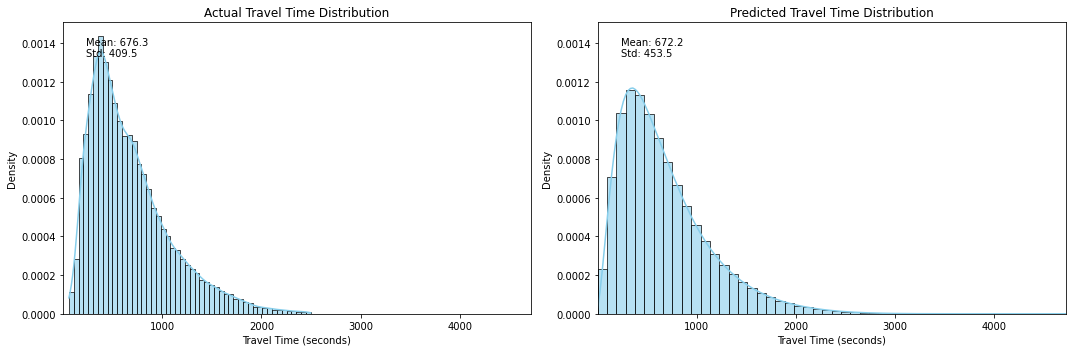

In [46]:


# Evaluate
results = gamma_kde.evaluate(X_test, y_test)


# Plot distributions
gamma_kde.plot_distributions(X_test, y_test)


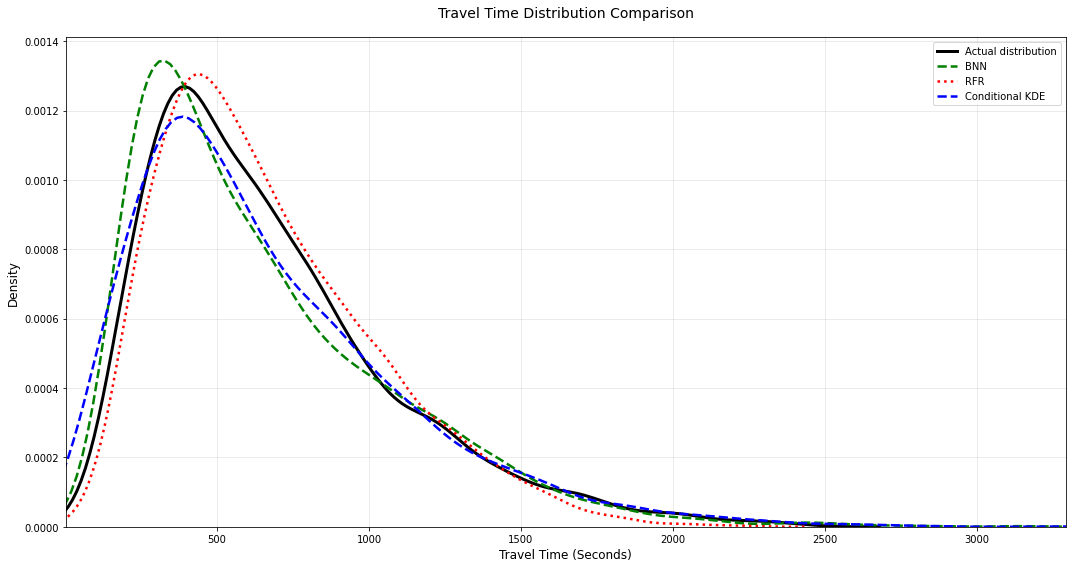

In [128]:
# Get predictions from each model
# BNN model
train_data, test_data = train_test_split(dataset3, test_size=0.2, random_state=42)
bnn_predictions = BNN_model.predict(test_data)

# Random Forest model 
rf_pred = model_random_forest.predict_distribution(test_df[features].values)
rf_predictions = {
   'predictions': {
       'predictions': rf_pred['predictions'],
       'mean': rf_pred['mean'],
       'std': rf_pred['std'],
       'quantiles': rf_pred['quantiles']
   }
}

# KDE model
X_test = prepare_data(test_df)[0]
kde_predictions = gamma_kde.predict_distribution_with_stats(X_test)

predictions_list = [bnn_predictions, rf_predictions, kde_predictions]

plot_model_distributions(test_df['travel_time'].values,
                       predictions_list,
                       model_names=['BNN', 'RFR', 'Conditional KDE'])

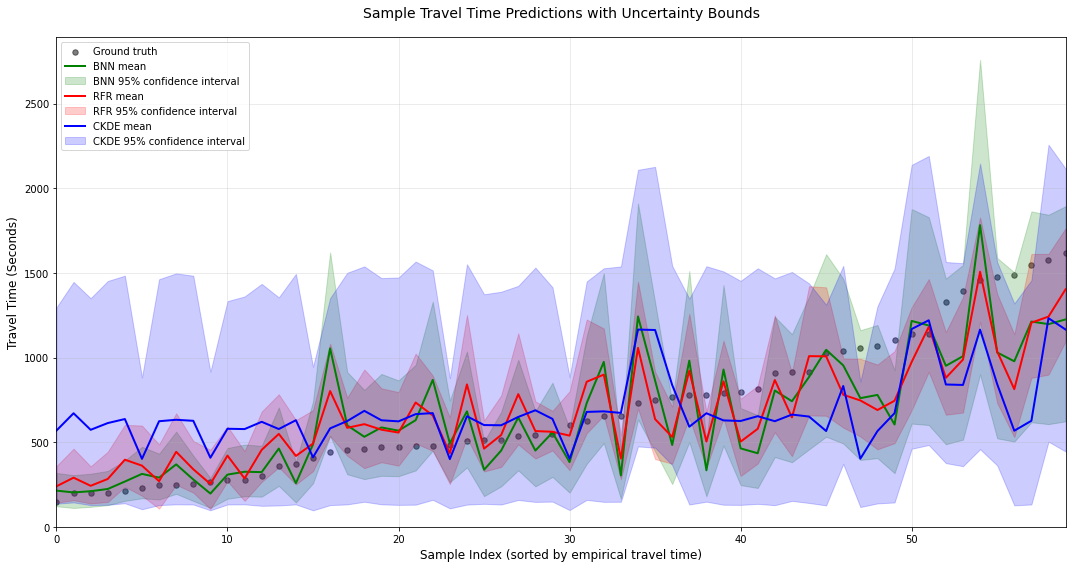

In [140]:
def plot_credible_intervals_comparison(test_df, pred_list, model_names, num_samples=60):
    plt.figure(figsize=(15, 8))
    actual = test_df['travel_time'].values[:num_samples]
    sort_idx = np.argsort(actual)
    actual_sorted = actual[sort_idx]

    # Get minimum value to set y-axis start
    min_val = min(actual_sorted)
    for pred in pred_list:
        if 'predictions' in pred and isinstance(pred['predictions'], dict):
            min_val = min(min_val, pred['predictions']['quantiles'][0].min())
        else:
            min_val = min(min_val, pred['quantiles'][0].min())

    plt.scatter(range(num_samples), actual_sorted, color='black', label='Ground truth', alpha=0.5, s=30)

    colors = ['green', 'red', 'blue']

    for i, pred in enumerate(pred_list):
        if i == 1:
            mean_sorted = pred['predictions']['mean'][sort_idx]
            lower_bounds = pred['predictions']['quantiles'][0][sort_idx]
            upper_bounds = pred['predictions']['quantiles'][4][sort_idx]
        else:
            mean_sorted = pred['mean'][sort_idx]
            lower_bounds = pred['quantiles'][0][sort_idx]
            upper_bounds = pred['quantiles'][4][sort_idx]

        plt.plot(range(num_samples), mean_sorted, 
                 color=colors[i], 
                 label=f'{model_names[i]} mean',
                 linewidth=2)
        plt.fill_between(range(num_samples), 
                         lower_bounds, upper_bounds,
                         color=colors[i], 
                         alpha=0.2, 
                         label=f'{model_names[i]} 95% confidence interval')

    plt.xlabel('Sample Index (sorted by empirical travel time)', fontsize=12)
    plt.ylabel('Travel Time (Seconds)', fontsize=12)
    plt.title('Sample Travel Time Predictions with Uncertainty Bounds', fontsize=14, pad=20)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, plt.ylim()[1])  # Set y-axis minimum to 90% of smallest value
    plt.xlim(0, num_samples - 1)  # Start x-axis exactly at 0
    plt.tight_layout()
    plt.show()


plot_credible_intervals_comparison(test_df, predictions_list, 
                                model_names=['BNN', 'RFR', 'CKDE'])


## 4. Estimate travel times threshold between centroids

In [ ]:
#read the centroids file
data = pd.read_csv("../Cities/Padam_terretory_01/Ressources/final_ready_test_data_centroids.csv")
data

In [ ]:
import pandas as pd
from datetime import datetime

def add_departure_times(df):
    # List of departure times to add
    departure_times = [
        '2024-12-01 07:00:00',
        '2024-12-01 10:00:00',
        '2024-12-01 12:00:00',
        '2024-12-01 17:00:00',
        '2024-12-01 20:00:00',
        
        '2024-12-02 07:00:00',
        '2024-12-02 10:00:00',
        '2024-12-02 12:00:00',
        '2024-12-02 17:00:00',
        '2024-12-02 20:00:00'
    ]
    
    # Convert times to datetime objects
    departure_times = [pd.to_datetime(time) for time in departure_times]
    
    # Create an empty list to store the repeated dataframes
    dfs = []
    
    # For each departure time, create a copy of the original dataframe with that time
    for time in departure_times:
        df_copy = df.copy()
        df_copy['departure_time'] = time
        dfs.append(df_copy)
    
    # Concatenate all dataframes
    result_df = pd.concat(dfs, ignore_index=True)
    
    return result_df

In [ ]:
data_with_departure_times = add_departure_times(data)

In [ ]:
#  Add the time features needed for the model
data_with_departure_times['departure_time_hour'] = data_with_departure_times['departure_time'].dt.hour
data_with_departure_times['departure_time_minute'] = data_with_departure_times['departure_time'].dt.minute
data_with_departure_times['departure_time_seconds'] = data_with_departure_times['departure_time'].dt.second
data_with_departure_times['departure_time_day_of_week'] = data_with_departure_times['departure_time'].dt.dayofweek
data_with_departure_times['departure_time_day_of_month'] = data_with_departure_times['departure_time'].dt.day
data_with_departure_times['departure_time_month'] = data_with_departure_times['departure_time'].dt.month

# Add cyclical time features
data_with_departure_times['departure_time_hour_sin'] = np.sin(2 * np.pi * data_with_departure_times['departure_time_hour']/24)
data_with_departure_times['departure_time_hour_cos'] = np.cos(2 * np.pi * data_with_departure_times['departure_time_hour']/24)
data_with_departure_times['departure_time_day_of_week_sin'] = np.sin(2 * np.pi * data_with_departure_times['departure_time_day_of_week']/7)
data_with_departure_times['departure_time_day_of_week_cos'] = np.cos(2 * np.pi * data_with_departure_times['departure_time_day_of_week']/7)
data_with_departure_times['departure_time_month_sin'] = np.sin(2 * np.pi * data_with_departure_times['departure_time_month']/12)
data_with_departure_times['departure_time_month_cos'] = np.cos(2 * np.pi * data_with_departure_times['departure_time_month']/12)

In [ ]:
# Using a dictionary to map old names to new names
data_with_departure_times = data_with_departure_times.rename(columns={
    'centroid_x_departure': 'departure_longitude',
    'centroid_y_departure': 'departure_latitude',
    'centroid_x_arrival':'arrival_longitude',
    'centroid_y_arrival': 'arrival_latitude'
})

In [ ]:
data_with_departure_times=data_with_departure_times[['departure_latitude', 'departure_longitude', 'arrival_latitude',
                    'arrival_longitude', 'departure_time_hour', 'departure_time_minute',
                    'departure_time_seconds', 'departure_time_day_of_week',
                    'departure_time_day_of_month', 'departure_time_month',
                    'departure_time_hour_sin', 'departure_time_hour_cos',
                    'departure_time_day_of_week_sin', 'departure_time_day_of_week_cos',
                    'departure_time_month_sin', 'departure_time_month_cos',
                    'route_distance']]

#### Travel Time Prediction 

In [ ]:
# Define features used for travel time prediction
features = [
    # Geographic coordinates
    'departure_latitude', 'departure_longitude',  # Starting point coordinates
    'arrival_latitude', 'arrival_longitude',      # Destination coordinates
    
    # Raw time features
    'departure_time_hour',         # Hour of departure (0-23)
    'departure_time_minute',       # Minute of departure (0-59)
    'departure_time_seconds',      # Seconds of departure (0-59)
    'departure_time_day_of_week',  # Day of week (0-6, 0=Monday)
    'departure_time_day_of_month', # Day of month (1-31)
    'departure_time_month',        # Month (1-12)
    
    # Cyclical time features (transformed using sine and cosine)
    'departure_time_hour_sin',           # Cyclical representation of hour
    'departure_time_hour_cos',           # Ensures continuity between 23:00 and 00:00
    'departure_time_day_of_week_sin',    # Cyclical representation of day of week
    'departure_time_day_of_week_cos',    # Ensures continuity between Sunday and Monday
    'departure_time_month_sin',          # Cyclical representation of month
    'departure_time_month_cos',          # Ensures continuity between December and January
    
    'route_distance'                     # Distance of the route in appropriate units
]

# Get unique days and hours from the dataset for prediction
days = df_combined['departure_time_day_of_month'].unique()  # Array of unique days
hours = df_combined['departure_time_hour'].unique()         # Array of unique hours

# Initialize nested dictionary to store predictions for each day and hour
daily_hourly_predictions = {}

# Iterate through each day
for day in days:
    print(f"Processing day {day}")
    daily_hourly_predictions[day] = {}  # Initialize inner dictionary for this day
    
    # Iterate through each hour
    for hour in hours:
        print(f"Predicting for day {day}, hour {hour}")
        
        # Filter dataset to only include trips from specific day and hour
        day_hour_data = df_combined[
            (df_combined['departure_time_day_of_month'] == day) & 
            (df_combined['departure_time_hour'] == hour)
        ]
        
        # Check if there are any trips in this day/hour combination
        if len(day_hour_data) > 0:
            # Generate predictions at different confidence levels
            # Higher confidence level means wider prediction interval
            thresholds = predictor.predict_thresholds(
                day_hour_data[features],  # Input features for prediction
                confidence_levels=[0.95, 0.70, 0.50, 0.25]  # Different confidence intervals
            )
            # Store predictions in nested dictionary
            daily_hourly_predictions[day][hour] = thresholds
        else:
            print(f"No data for day {day}, hour {hour}")
            daily_hourly_predictions[day][hour] = None  # Store None if no data available



In [ ]:
# Threshold Assignment for Multi-Level Travel Time Predictions

# Initialize threshold columns in the dataframe
df_combined['travel_time_95'] = None  # 95% confidence level threshold
df_combined['travel_time_70'] = None  # 70% confidence level threshold  
df_combined['travel_time_50'] = None  # 50% confidence level threshold
df_combined['travel_time_25'] = None  # 25% confidence level threshold

# Assign predicted thresholds to each trip based on departure day and hour
for day in daily_hourly_predictions.keys():
   for hour in daily_hourly_predictions[day].keys():
       # Skip if no predictions exist for this time period
       if daily_hourly_predictions[day][hour] is None:
           continue
           
       # Create boolean mask to identify trips from specific day/hour
       day_hour_mask = (df_combined['departure_time_day_of_month'] == day) & \
                      (df_combined['departure_time_hour'] == hour)
       
       # Get row indices for trips in current time period
       day_hour_indices = df_combined[day_hour_mask].index
       
       # Get number of trips in current time period
       n_predictions = len(day_hour_indices)
       
       # Assign threshold predictions if trips exist
       if n_predictions > 0:
           # For each confidence level, assign predicted thresholds to corresponding rows
           df_combined.loc[day_hour_indices, 'travel_time_95'] = \
               daily_hourly_predictions[day][hour][0.95]['threshold'][:n_predictions]
           df_combined.loc[day_hour_indices, 'travel_time_70'] = \
               daily_hourly_predictions[day][hour][0.70]['threshold'][:n_predictions]
           df_combined.loc[day_hour_indices, 'travel_time_50'] = \
               daily_hourly_predictions[day][hour][0.50]['threshold'][:n_predictions]
           df_combined.loc[day_hour_indices, 'travel_time_25'] = \
               daily_hourly_predictions[day][hour][0.25]['threshold'][:n_predictions]

## 5. Create GTFS files

In [ ]:
from library.create_and_join_gtfs import (
    create_gtfs_from_trips,
    save_gtfs_files,
    joinGTFS,
    exportGTFS
)

In [ ]:


# Using default threshold (travel_time_25)
gtfs_data = create_gtfs_from_trips(trips_df,"travel_time_25")

# Or specifying a different threshold
gtfs_data_25 = create_gtfs_from_trips(trips_df, travel_time_threshold='travel_time_25')

# Save with default threshold
save_gtfs_files(gtfs_data, "path/to/output")

# Or save with specific threshold
save_gtfs_files(gtfs_data_95, "path/to/output", travel_time_threshold='travel_time_25')

# For joining and exporting GTFS files:
merged_gtfs = joinGTFS(gtfs_dataset1, gtfs_dataset2)
exportGTFS("path/to/output", merged_gtfs)  # These functions don't need the threshold parameter